In [2]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import sys
from os.path import join as oj
sys.path.append('..')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import matching
from tqdm import tqdm
from config import *
import data
import util

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')
df = df[['id', 'fname_final', 'age', 'gender', 'race_pred', 'race4_pred', 'eyeglasses']] # only keep few keys to speed things up
df['Race=black'] = (df['race_pred'] == 'Black').astype(int)

In [3]:
# load pairwise facial dicts
print('loading dists')
dists_gan = data.get_dists('gan')
dists_facial = data.get_dists('facial')
dists_vgg = data.get_dists('vgg')
print('all dists loaded')

loading dists
all dists loaded


# find best matches

In [4]:
'''
we want to find matched pairs
the pairs should change only one attribute at a time (but we may vary 2 to make a transect)
"main" image is matched stringently
"reference" image is matched more loosely
'''

# specify dists for matching
dists_match_name = 'gan_constrained'
dists_ref = dists_vgg


if dists_match_name == 'facial':
    dists_match = dists_facial
elif dists_match_name == 'gan':
    dists_match = dists_gan
elif dists_match_name == 'gan_constrained':
    dists_match = dists_gan + (dists_facial > 0.6) * 1e6 # constraint for missclassificaiton

n = dists_match.shape[0]

In [ ]:
# specify things to vary (these should all be binary columns)
# id willl automatically be different when we vary gender, race bc these things 
# are forced to be preserved in data.py
attrs_to_vary = ['gender'] #Race=black'] # eyeglasses, gender, 'Race=black'
NUM_MATCHES = 10
MIN_REF_DIST_THRESH_UPPER = 1e6 # 1 will weed out any crazy matches
MIN_REF_DIST_THRESH_LOWER = 1e-2 # 1 will weed out any matches that are too close


pairwise_constraints = np.zeros((n, n)).astype(bool) # extra constraints for matching
matches = matching.get_matches(df, dists_match, dists_ref, pairwise_constraints, attrs_to_vary,
                               NUM_MATCHES, MIN_REF_DIST_THRESH_UPPER, MIN_REF_DIST_THRESH_LOWER)

In [6]:
matches = pd.DataFrame.from_dict(matches).infer_objects()
matches.to_pickle(f'processed/14_matches_{attrs_to_vary[0]}_{matches.shape[0]}_{dists_match_name}.pkl')

# analyze matches

In [7]:
print([k for k in os.listdir('processed/') if '14_' in k])
matches = pd.read_pickle(f'processed/14_matches_{attrs_to_vary[0]}_{matches.shape[0]}_{dists_match_name}.pkl')

['14_matches_gender_5_facial.pkl', '14_matches_gender_1_gan_constrained.pkl', '14_matches_gender_10_gan_constrained.pkl', '14_matches_gender_3_gan_constrained.pkl']


10it [00:00, 17.12it/s]


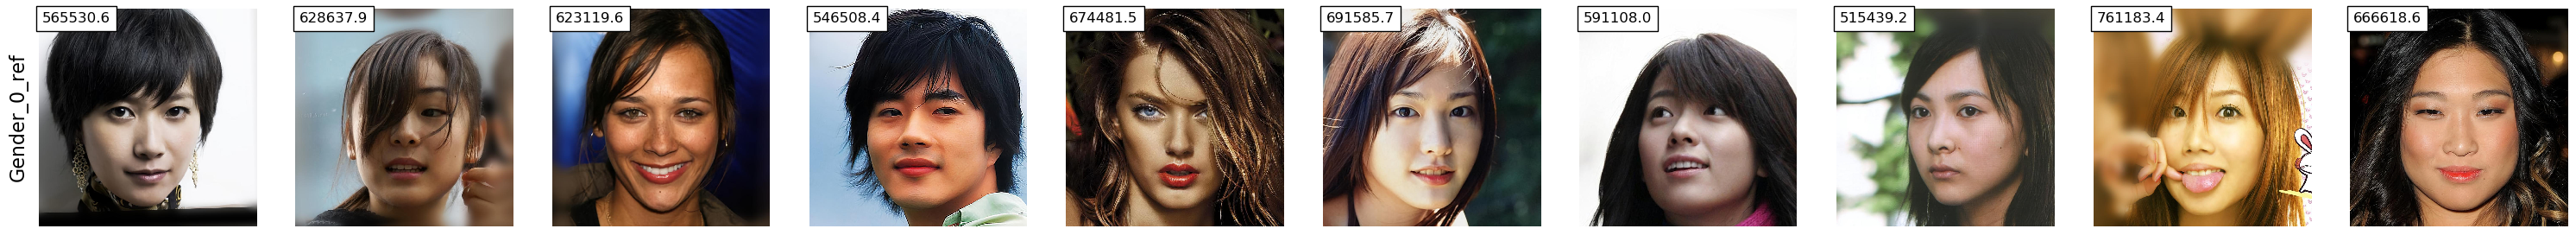

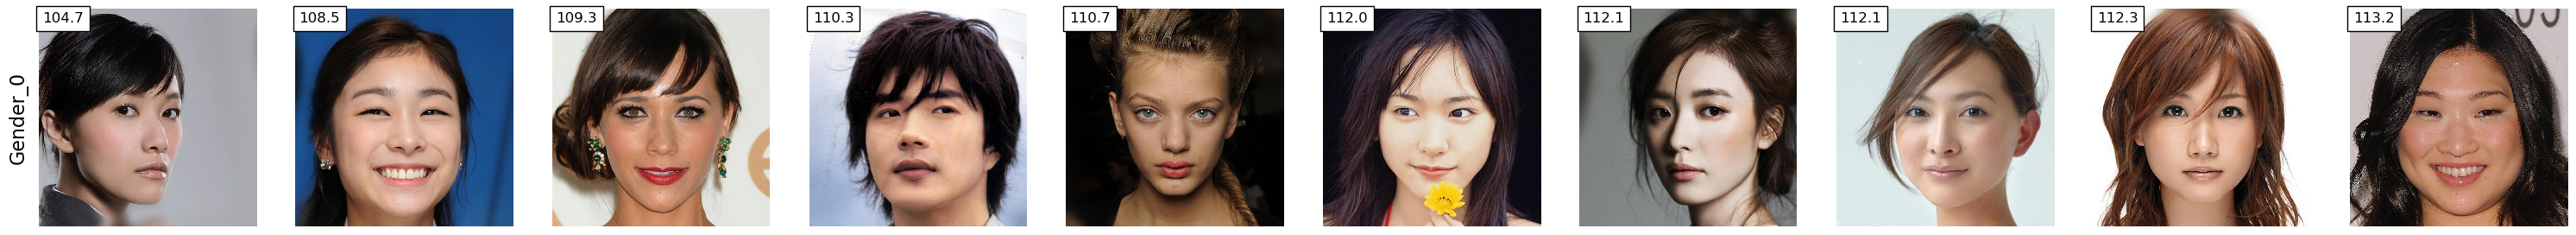

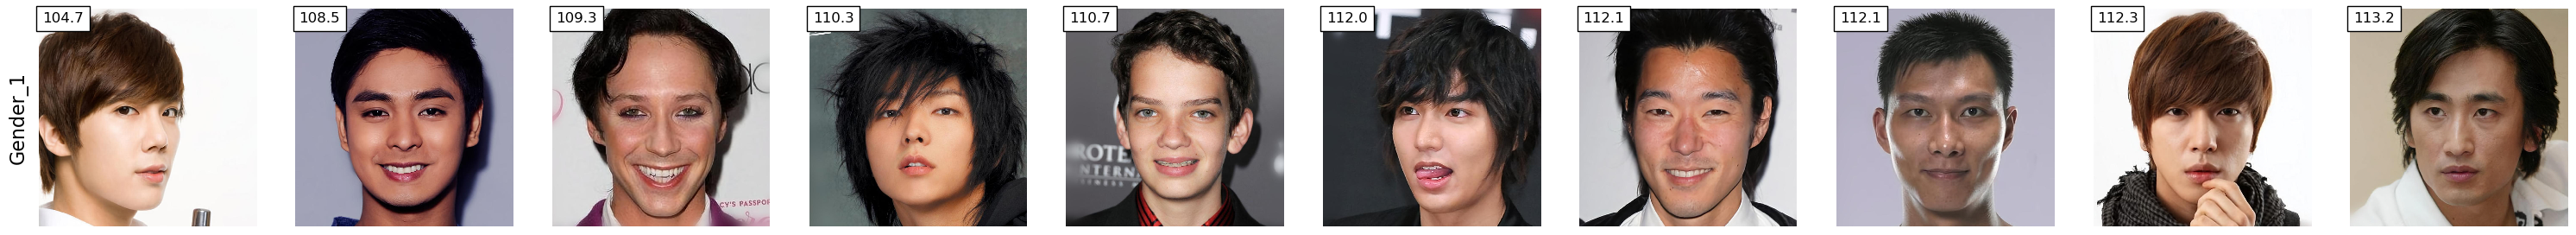

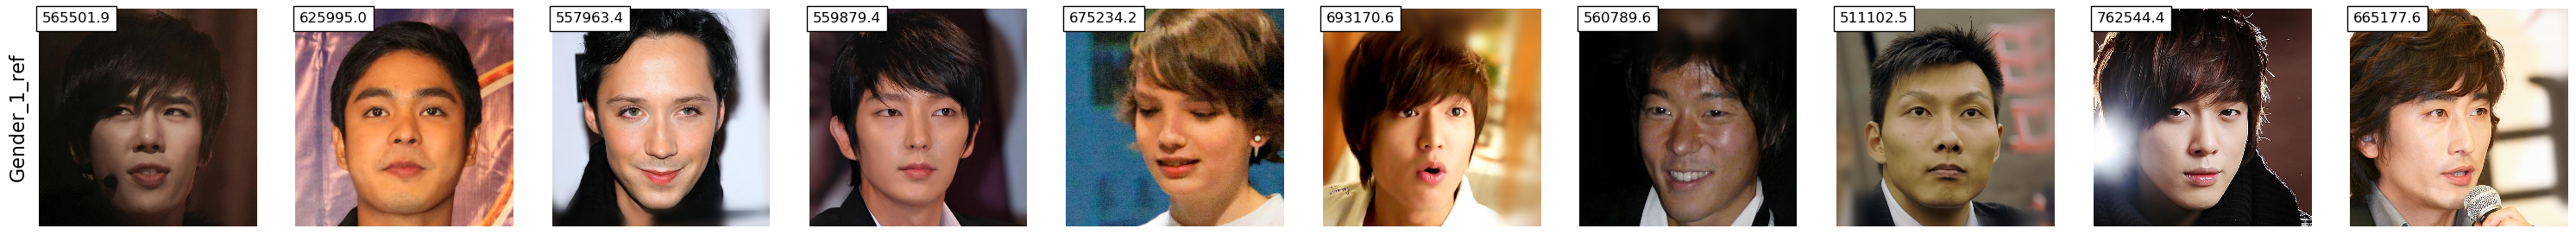

In [10]:
N_PLOT = 10
def get_im_from_match_key(k, match):
    d = df.iloc[int(match[k])]
    return mpimg.imread(oj(DIR_IMS, d.fname_final))

for a in attrs_to_vary:
    ks = [f'{a}_0_ref', f'{a}_0', f'{a}_1', f'{a}_1_ref']
    r = {
        k: [] for k in ks
    }
    dist_keys = {
        f'{a}_0': 'dist',
        f'{a}_1': 'dist',
        f'{a}_0_ref': 'dist_ref0',
        f'{a}_1_ref': 'dist_ref1'
    }

    for i, match in tqdm(matches.iterrows()):
        for k in r.keys():
            r[k].append(get_im_from_match_key(k, match))

    kwargs = {
        'dpi': 150
    }
    for i, k in enumerate(ks):
        util.plot_row(r[k], annot_list=matches[dist_keys[k]][:N_PLOT].round(1),
                      ylab=k.capitalize())
        plt.savefig(f'results/{k}.png', **kwargs)

In [23]:
matches

gender_0  gender_1  gender_0_ref  gender_1_ref        dist    dist_ref0  \
0     17651     26797         15396         28168  104.697890  565530.5625   
1     28983     20246         13304         10907  108.483083  628637.9375   
2     25172     28203         23615         19540  109.306678  623119.6250   
3      8759      6522         11270         20082  110.260862  546508.3750   
4      2619      8493          2622         11537  110.664833  674481.5000   
5     29067     16822         28622         24908  112.041871  691585.6875   
6     20757     27743         17073         24431  112.111645  591108.0000   
7     16837     27859         16622         25339  112.129750  515439.2500   
8     24681     21488         10632         18798  112.287924  761183.3750   
9      6962     16791          9499         19453  113.231666  666618.5625   

     dist_ref1  
0  565501.8750  
1  625995.0000  
2  557963.4375  
3  559879.3750  
4  675234.2500  
5  693170.6250  
6  560789.5625  
7  511102.5000  
8  762544.4375  
9  665177.5625